# Analysis of Baseball dataset

## Through the eyes of an european profane

I literally know nothing about baseball... But I like sports in general. This seems to be a huge database collected by passionate people. I decide to take it slow, starting by analyzing the master table with players information.

## Who plays baseball ?

- Where players are from (country) ?
- When (age) players make ther debut ? 
- When (age) players usally retire ? 
- How long lasts a baseball carrier ?
- What is the the morphotype of a baseball player ? 
- Has the average morphotype changed in history of baseball ?

In [1]:
import pandas as pd

import baseball #module with cleaning and plotting functions

%matplotlib inline

We start by reading and cleaning the master dataset. The cleaning does the following:

- Any row with a null playerID is dropped
- Unused columns are dropped
- We use the playerID column as index in the data frame
- Rename some countries (replace abreviation by full name)
- Convert weights into kilograms and heights into centimeters
- Convert debut and finalGame into datetime objects
- Create a birthDate column as a datetime object

In [2]:
master_df = baseball.read_master()
master_df.head()

,birthYear,birthCountry,nameFirst,nameLast,nameGiven,weight,height,debut,finalGame,birthDate
playerID,,,,,,,,,,
aardsda01,1981.0,USA,David,Aardsma,David Allan,97.522280,190.50,2004-04-06,2015-08-23,1981-12-27
aaronha01,1934.0,USA,Hank,Aaron,Henry Louis,81.646560,182.88,1954-04-13,1976-10-03,1934-02-05
aaronto01,1939.0,USA,Tommie,Aaron,Tommie Lee,86.182480,190.50,1962-04-10,1971-09-26,1939-08-05
aasedo01,1954.0,USA,Don,Aase,Donald William,86.182480,190.50,1977-07-26,1990-10-03,1954-09-08
abadan01,1972.0,USA,Andy,Abad,Fausto Andres,83.460928,185.42,2001-09-10,2006-04-13,1972-08-25


### Country of origin ?

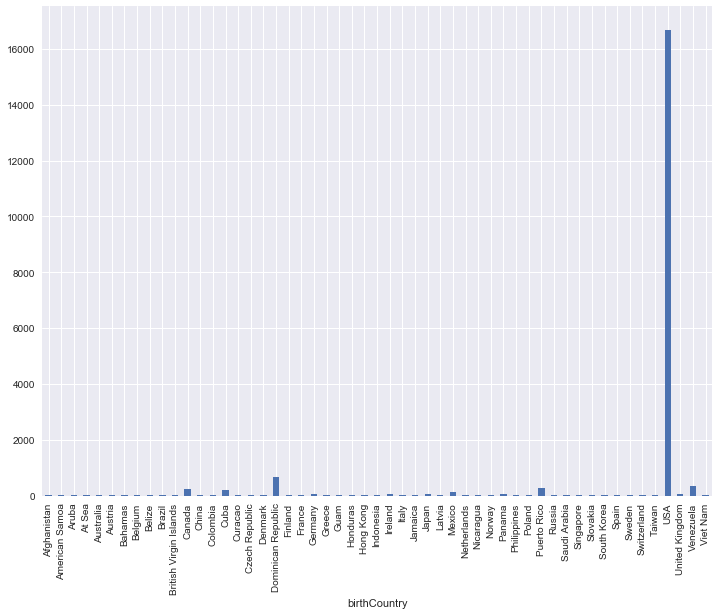

In [3]:
master_df.groupby('birthCountry').count().max(axis=1).plot.bar(figsize=(12, 9))

Players are massively born in the USA. Other major countries of origin are Dominican Republic, Canada, Puerto Rico, Venezuela and Cuba.

### What is the morphology of a baseball player ?

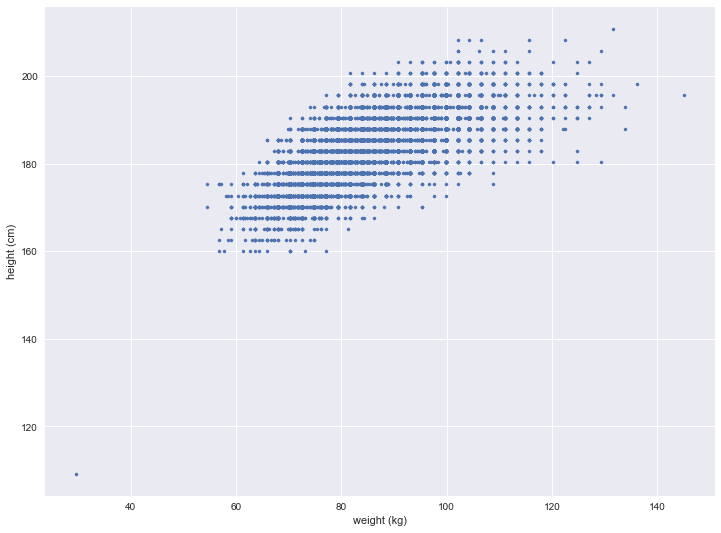

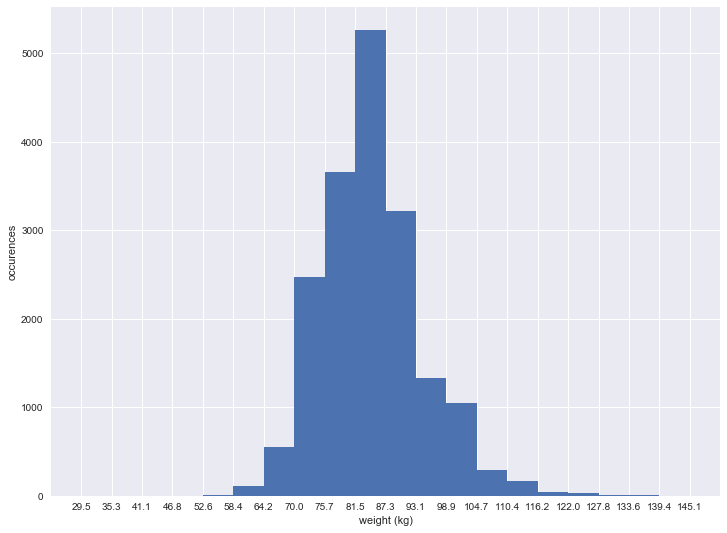

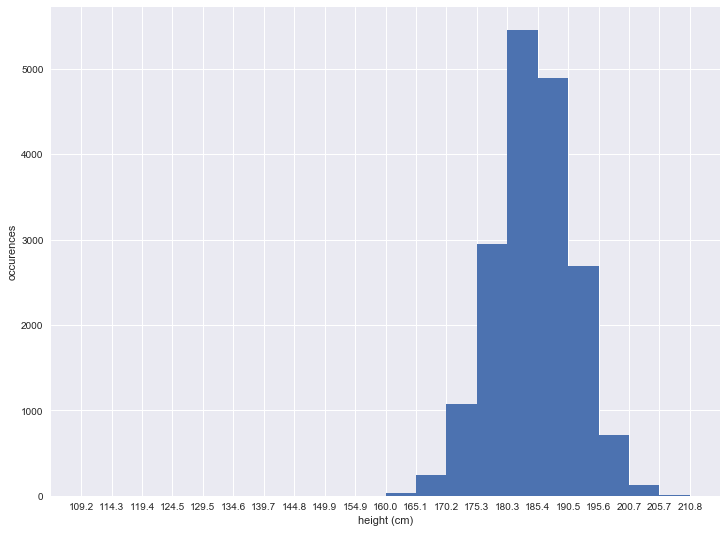

In [4]:
weight_height_not_null = master_df[master_df['weight'].notnull() & master_df['height'].notnull()]
baseball.scatter_plot(weight_height_not_null['weight'], weight_height_not_null['height'], xlabel="weight (kg)", 
                      ylabel="height (cm)", size=10)
baseball.hist_plot(weight_height_not_null['weight'], bins=20, xlabel="weight (kg)", ylabel="occurences")
baseball.hist_plot(weight_height_not_null['height'], bins=20, xlabel="height (cm)", ylabel="occurences")

In [5]:
weight_height_not_null.describe()

,birthYear,weight,height
count,18187.000000,18197.000000,18197.000000
mean,1934.208336,84.563637,183.608905
std,40.064377,9.754851,6.603959
min,1835.000000,29.483480,109.220000
25%,1899.000000,77.110640,180.340000
50%,1941.000000,83.914520,182.880000
75%,1970.000000,90.718400,187.960000
max,1996.000000,145.149440,210.820000


Baseball player is between 60 and 120 kilograms with a median weight of 83.9 kilograms and between 1.60 and 2.00 meters with a median of 1.83 meters.

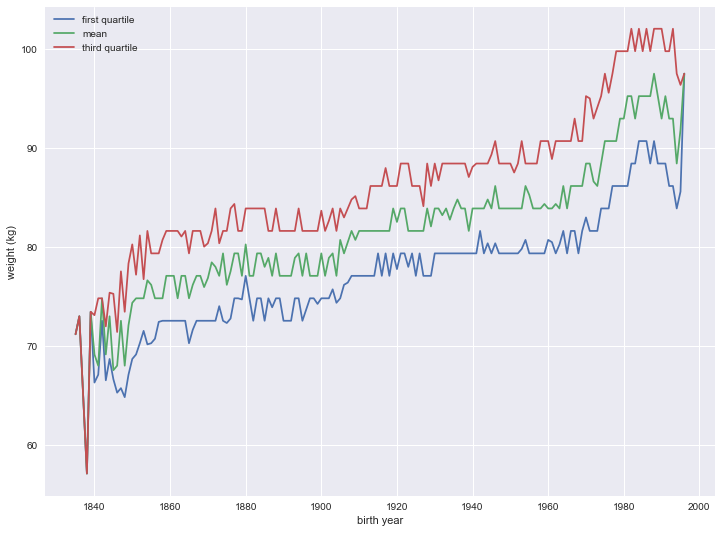

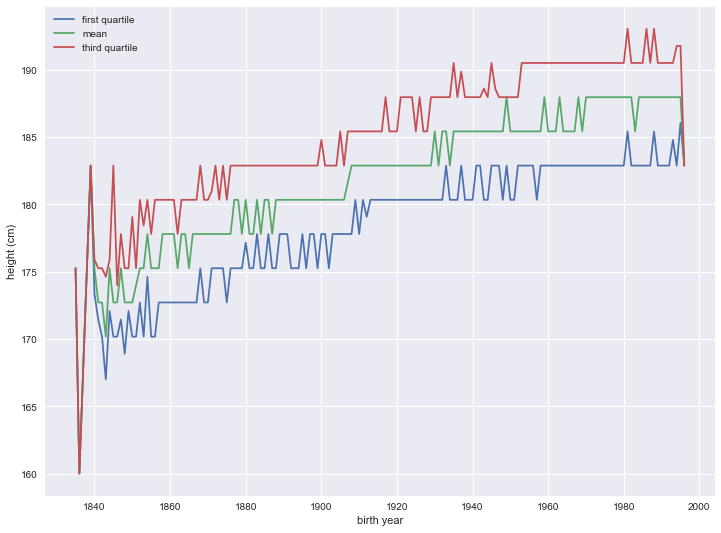

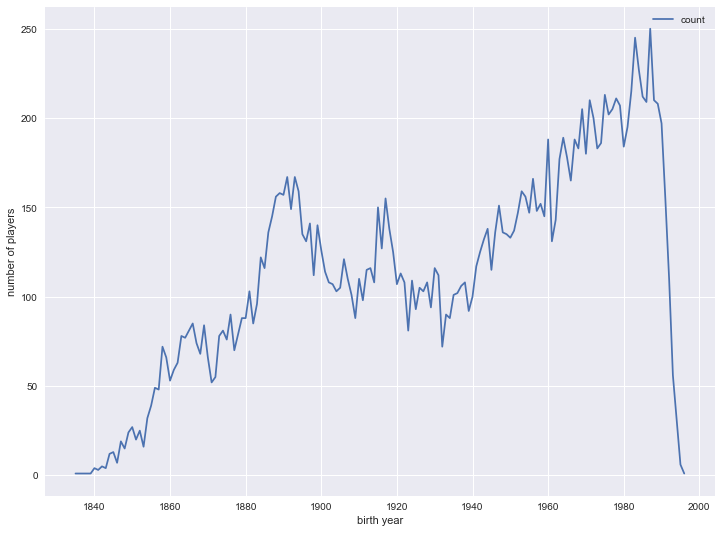

In [6]:
#We create a MultiIndex data frame and group by birth year
weight_height_birthyear = weight_height_not_null.groupby('birthYear', as_index=False).describe()
xs = [weight_height_birthyear['birthYear']['mean']] * 3
ys = [weight_height_birthyear['weight']['25%'], 
      weight_height_birthyear['weight']['50%'], 
      weight_height_birthyear['weight']['75%']]
labels = ['first quartile', 'mean', 'third quartile']
baseball.line_plot(xs, ys, labels=labels, xlabel="birth year", ylabel="weight (kg)")
ys = [weight_height_birthyear['height']['25%'], 
      weight_height_birthyear['height']['50%'], 
      weight_height_birthyear['height']['75%']]
baseball.line_plot(xs, ys, labels=labels, xlabel="birth year", ylabel="height (cm)")
xs = [weight_height_birthyear['birthYear']['mean']]
ys = [weight_height_birthyear['birthYear']['count']]
baseball.line_plot(xs, ys, xlabel="birth year", ylabel="number of players")

Both weight and height of players tend to increase along time. The typical morphology of baseball player has significantly changed: the height has regularly increased while weight has accelerated from the 70's.

Number of players born before 1850 and after 1990 is quite low and shall not be considered. There are two generations of people born around 1900 or 1920 for which we note a decrease of number of players probably people engaged in first and second world war. Apart from that, the number of players tends to increase.

### Baseball player carriers

We now calculate age of debuts and length of baseball carrier (delta between debut and final game). We first remove any rows for which one of these dates is null.

In [7]:
dates_not_null = master_df[master_df["birthDate"].notnull() & master_df["debut"].notnull()
                           & master_df["finalGame"].notnull()]
dates_not_null.head()

,birthYear,birthCountry,nameFirst,nameLast,nameGiven,weight,height,debut,finalGame,birthDate
playerID,,,,,,,,,,
aardsda01,1981.0,USA,David,Aardsma,David Allan,97.522280,190.50,2004-04-06,2015-08-23,1981-12-27
aaronha01,1934.0,USA,Hank,Aaron,Henry Louis,81.646560,182.88,1954-04-13,1976-10-03,1934-02-05
aaronto01,1939.0,USA,Tommie,Aaron,Tommie Lee,86.182480,190.50,1962-04-10,1971-09-26,1939-08-05
aasedo01,1954.0,USA,Don,Aase,Donald William,86.182480,190.50,1977-07-26,1990-10-03,1954-09-08
abadan01,1972.0,USA,Andy,Abad,Fausto Andres,83.460928,185.42,2001-09-10,2006-04-13,1972-08-25


In [8]:
#We convert timedelta from pandas into days while calculating age at debut and carrier length
delta_to_days = lambda x: float(x.days / 365.25)
age_at_debut = (dates_not_null["debut"] - dates_not_null["birthDate"]).apply(delta_to_days)
carrier_length = (dates_not_null["finalGame"] - dates_not_null["debut"]).apply(delta_to_days)

#We create a dedicated dataframe for this processing
carrier_df = pd.DataFrame({"birthYear": dates_not_null["birthYear"], 
                          "ageAtDebut": age_at_debut,
                          "carrierLenght": carrier_length})
carrier_df.head()

,ageAtDebut,birthYear,carrierLenght
playerID,,,
aardsda01,22.275154,1981.0,11.378508
aaronha01,20.183436,1934.0,22.475017
aaronto01,22.680356,1939.0,9.462012
aasedo01,22.880219,1954.0,13.188227
abadan01,29.043121,1972.0,4.588638


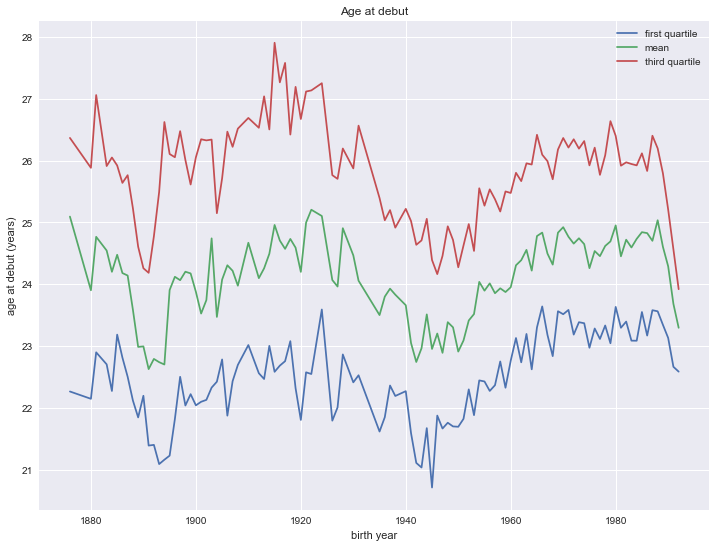

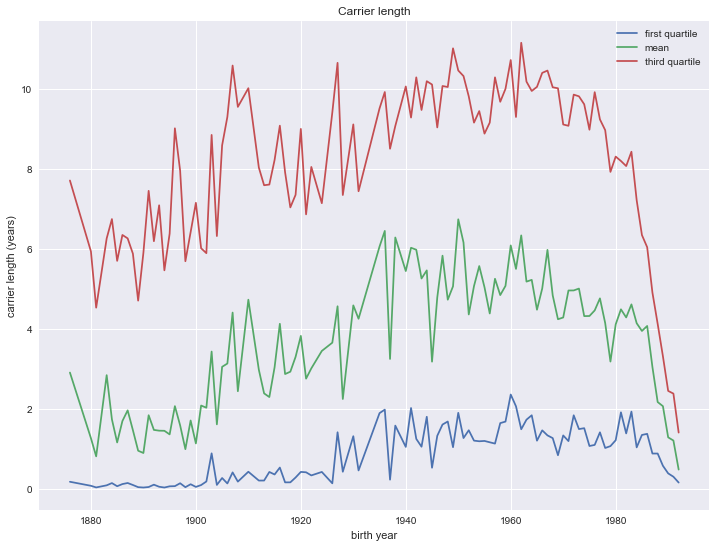

In [9]:
#We calculate quartiles as a function of birth year
carrier_birthyear = carrier_df.groupby("birthYear", as_index=False).describe()

#We only keep years for which we have at least 100 players (this prevents having noisy plots)
carrier_birthyear = carrier_birthyear[carrier_birthyear["birthYear"]["count"] >= 100]

xs = [carrier_birthyear['birthYear']['mean']] * 3
ys = [carrier_birthyear['ageAtDebut']['25%'], 
      carrier_birthyear['ageAtDebut']['50%'], 
      carrier_birthyear['ageAtDebut']['75%']]
labels = ['first quartile', 'mean', 'third quartile']
baseball.line_plot(xs, ys, labels=labels, xlabel="birth year", ylabel="age at debut (years)", title="Age at debut")

xs = [carrier_birthyear['birthYear']['mean']] * 3
ys = [carrier_birthyear['carrierLenght']['25%'], 
      carrier_birthyear['carrierLenght']['50%'], 
      carrier_birthyear['carrierLenght']['75%']]
labels = ['first quartile', 'mean', 'third quartile']
baseball.line_plot(xs, ys, labels=labels, xlabel="birth year", ylabel="carrier length (years)", 
                   title="Carrier length")

There is no significant change in age at debut, but we can notice that compared to other sports (at least sports played in european continent), age at debut is quite high: only 75% of player have less than 26 years old when starting playing in a baseball league and only one out of four is under 22/23 years old.

Carriers seems to be quite short (again compared to european sports I know) with an average around 4 years old (on the decrease since the 60's).

I am not sure if this is a charectistic shared with other US sports or if this is something related to baseball.

## Baseball teams

- Which are active teams in National League and American League ?
- Is there any team that changed league or division in its history ?
- How many titles (league winner) teams have in their respective league (including non-active teams) ?
- Which are the teams with the most wins in World Series in history ?
- How many world series have been won by teams from National League and American League ?
- Which teams have the best win ratio after regular season ?
- Which teams have the best average win ratio on multiple seasons ?
- How attendance is related to win ratio in league ?

We read the teams dataset and merge it with the teams franchises dataset. We also clean the dataset this way:
* Unused columns are dropped
* Teams which does not belong either to National League or American League are removed
* active column is converted to a bool
* LgWin, DivWin, WSWin columns are converted to an integer (1 if won, 0 otherwise)
* rows for which divID is null are removed

In [10]:
teams_df = baseball.read_teams()
teams_df.tail()

,yearID,lgID,teamID,divID,Rank,G,Ghome,W,L,DivWin,...,BBA,SOA,E,DP,FP,name,park,attendance,franchName,active
2830,2012,AL,TBA,E,3,162,81.0,90,72,0,...,469,1383,114,155.0,0.981,Tampa Bay Rays,Tropicana Field,1559681.0,Tampa Bay Rays,True
2831,2013,AL,TBA,E,2,163,81.0,92,71,0,...,482,1310,59,147.0,0.990,Tampa Bay Rays,Tropicana Field,1510300.0,Tampa Bay Rays,True
2832,2014,AL,TBA,E,4,162,81.0,77,85,0,...,482,1437,88,96.0,0.985,Tampa Bay Rays,Tropicana Field,1446464.0,Tampa Bay Rays,True
2833,2015,AL,TBA,E,4,162,84.0,80,82,0,...,477,1355,95,118.0,0.984,Tampa Bay Rays,Tropicana Field,1287054.0,Tampa Bay Rays,True
2834,2016,AL,TBA,E,5,162,81.0,68,94,0,...,491,1357,94,129.0,0.984,Tampa Bay Rays,Tropicana Field,1286163.0,Tampa Bay Rays,True


### Teams in leagues and divisions

In [11]:
#Let's create a dataframe with active teams for each major league
teams_nl_active = set(pd.unique(teams_df[teams_df["active"] & (teams_df["lgID"] == "NL")]["franchName"]))
teams_nl_2016 = set(pd.unique(teams_df[(teams_df["yearID"] == 2016) & (teams_df["lgID"] == "NL")]["franchName"]))
print teams_nl_active, len(teams_nl_active)
print teams_nl_2016, len(teams_nl_2016)
print teams_nl_active - teams_nl_2016

set(['Houston Astros', 'Philadelphia Phillies', 'New York Mets', 'Los Angeles Dodgers', 'Milwaukee Brewers', 'Cincinnati Reds', 'Atlanta Braves', 'San Francisco Giants', 'St. Louis Cardinals', 'San Diego Padres', 'Arizona Diamondbacks', 'Pittsburgh Pirates', 'Washington Nationals', 'Florida Marlins', 'Chicago Cubs', 'Colorado Rockies']) 16
set(['Philadelphia Phillies', 'New York Mets', 'Los Angeles Dodgers', 'Milwaukee Brewers', 'Cincinnati Reds', 'Atlanta Braves', 'San Francisco Giants', 'St. Louis Cardinals', 'San Diego Padres', 'Arizona Diamondbacks', 'Pittsburgh Pirates', 'Washington Nationals', 'Florida Marlins', 'Chicago Cubs', 'Colorado Rockies']) 15
set(['Houston Astros'])


There are 16 active franchises based on information provided in franchises dataset but only 15 teams attended the National League in 2016. The missing franchise is Houston Astros. From wikipedia page (https://en.wikipedia.org/wiki/Houston_Astros) we can see that team was playing in the National League until 2012.

In [12]:
teams_al_active = set(pd.unique(teams_df[teams_df["active"] & (teams_df["lgID"] == "AL")]["franchName"]))
teams_al_2016 = set(pd.unique(teams_df[(teams_df["yearID"] == 2016) & (teams_df["lgID"] == "AL")]["franchName"]))
print teams_al_active, len(teams_al_active)
print teams_al_2016, len(teams_al_2016)
print teams_al_active - teams_al_2016

set(['Chicago White Sox', 'Houston Astros', 'Baltimore Orioles', 'Los Angeles Angels of Anaheim', 'Detroit Tigers', 'Boston Red Sox', 'New York Yankees', 'Oakland Athletics', 'Texas Rangers', 'Milwaukee Brewers', 'Minnesota Twins', 'Seattle Mariners', 'Tampa Bay Rays', 'Cleveland Indians', 'Toronto Blue Jays', 'Kansas City Royals']) 16
set(['Chicago White Sox', 'Houston Astros', 'Baltimore Orioles', 'Los Angeles Angels of Anaheim', 'Detroit Tigers', 'Boston Red Sox', 'New York Yankees', 'Oakland Athletics', 'Texas Rangers', 'Minnesota Twins', 'Seattle Mariners', 'Tampa Bay Rays', 'Cleveland Indians', 'Toronto Blue Jays', 'Kansas City Royals']) 15
set(['Milwaukee Brewers'])


There are 16 active franchises based on information provided in franchises dataset but only 15 teams attended the American League in 2016. The missing franchise is Milwaukee Brewers. From wikipedia page (https://en.wikipedia.org/wiki/Milwaukee_Brewers) we can see that team was playing in the American League until 1997.

We initialy had this question of teams changing league or division within a league. Let's find out when this happened and when. The method we are going to use is the following one:
* we group teams by franchise name, league and division
* we use an aggregate function (here count) but we can use any function, the point is to get a dataframe as result
* we only keep the columns we are interested in (franchName, yearID, lgID and divID)
* we create a new column named diffDivisions which is equal to 1. This will be used in the netx step to count the number of different divisions.
* we group by teams like before except we do not group by division. that is because we want to count how many different divisions the teams has been affiliated to.
* we use sum as aggregate functions, the sum of diffDivisions then contains the number of different divisions the teams has been affiliated to in a given league

In [13]:
franchises_group = teams_df.groupby(["franchName", "lgID", "divID"], as_index=False)
result = franchises_group.count()
result = result[["franchName", "lgID", "divID"]]
result = result.assign(diffDivision=1)
diff_divisions = result.groupby(["franchName", "lgID"]).sum()
diff_divisions[diff_divisions["diffDivision"] > 1].head(50)

,,diffDivision
franchName,lgID,
Atlanta Braves,NL,2
Chicago Cubs,NL,2
Chicago White Sox,AL,2
Cincinnati Reds,NL,2
Cleveland Indians,AL,2
Detroit Tigers,AL,2
Houston Astros,NL,2
Kansas City Royals,AL,2
Milwaukee Brewers,AL,3


There are 13 teams which have changed of division within the league they were affiliated to. Milwaukee Brewers for example have played in 3 different divisions in American League.

We can continue with the same method to get all teams which have their league of affiliation changed:

In [14]:
franchises_group = teams_df.groupby(["franchName", "lgID"], as_index=False)
result = franchises_group.count()
result = result[["franchName", "lgID"]]
result = result.assign(diffLeagues=1)
diff_leagues = result.groupby(["franchName"]).sum()
diff_leagues[diff_leagues["diffLeagues"] > 1].head()

,diffLeagues
franchName,
Houston Astros,2
Milwaukee Brewers,2


Without surprise we find again Milwaukee Brewers and Houston Astros. Just like we did when we tried to get active franchises and franchises involved in National League and American League in 2016. Those league changes seems to be rare.

We could have done the same using aggregate function after a group by franchise. The aggregate function receives as argument each column of the dataset. It is possible to use different aggregation function by column. This what is done below (althoug unnecessary here):

In [15]:
franchises_group = teams_df.groupby(["franchName", "lgID", "divID"], as_index=False)
result = franchises_group.count()
result = result[["franchName", "lgID", "divID"]]
result.head()

def count_changes_of_affiliation(x):
    return len(x.unique())

result.groupby("franchName").aggregate({"lgID": [count_changes_of_affiliation], "divID": [count_changes_of_affiliation]})

,lgID,divID
,count_changes_of_affiliation,count_changes_of_affiliation
franchName,,
Arizona Diamondbacks,1,1
Atlanta Braves,1,2
Baltimore Orioles,1,1
Boston Red Sox,1,1
Chicago Cubs,1,2
Chicago White Sox,1,2
Cincinnati Reds,1,2
Cleveland Indians,1,2


### Prize list

In [47]:
prize_list = teams_df[["franchName", "lgID", "LgWin", "WSWin"]].groupby(["franchName", "lgID"], as_index=False).sum()
prize_list.head()
#teams_df[["franchName", "lgID", "LgWin", "WSWin"]].groupby(["franchName", "lgID"], as_index=False).count()

,franchName,lgID,LgWin,WSWin
0,Arizona Diamondbacks,NL,1,1
1,Atlanta Braves,NL,5,1
2,Baltimore Orioles,AL,5,2
3,Boston Red Sox,AL,5,3
4,Chicago Cubs,NL,1,1


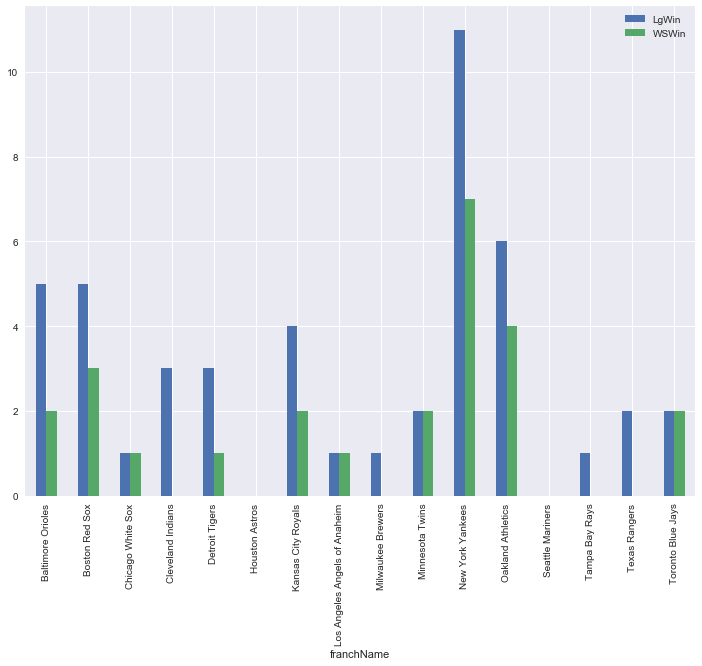

In [29]:
prize_list_al = prize_list[prize_list["lgID"] == "AL"]
prize_list_al.set_index(prize_list_al["franchName"]).plot.bar(figsize=(12, 9))

New York Yankees leads the American League with 11 wins. Only two teams never have won the league (Seattle Mariners and Houston Astros).

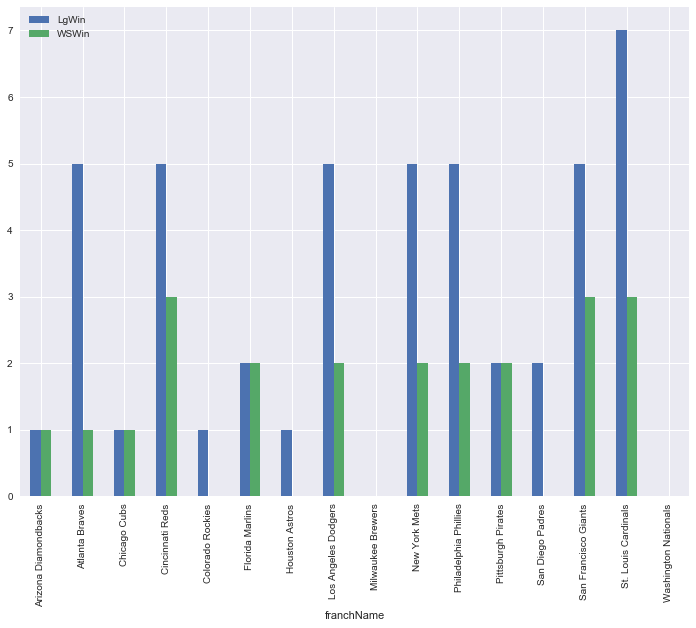

In [31]:
prize_list_nl = prize_list[prize_list["lgID"] == "NL"]
prize_list_nl.set_index(prize_list_nl["franchName"]).plot.bar(figsize=(12, 9))

St. Louis Cardinals leads the National League with 11 wins. Only two teams never have won the league (Washington Nationals and Milwaukee Brewers). But Milwaukee Brewers won once the American League.

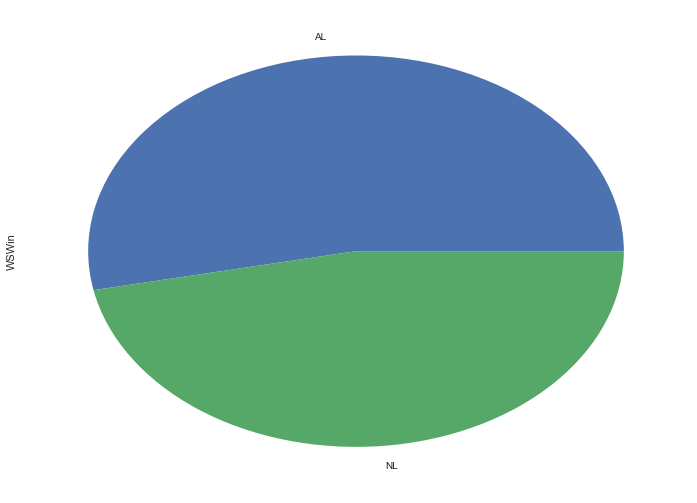

In [46]:
prize_list.groupby("lgID").sum()["WSWin"].plot.pie(figsize=(12, 9))

Teams from Americal League have won the world series more often than the teams from National League.

Here is the World Series prize list:

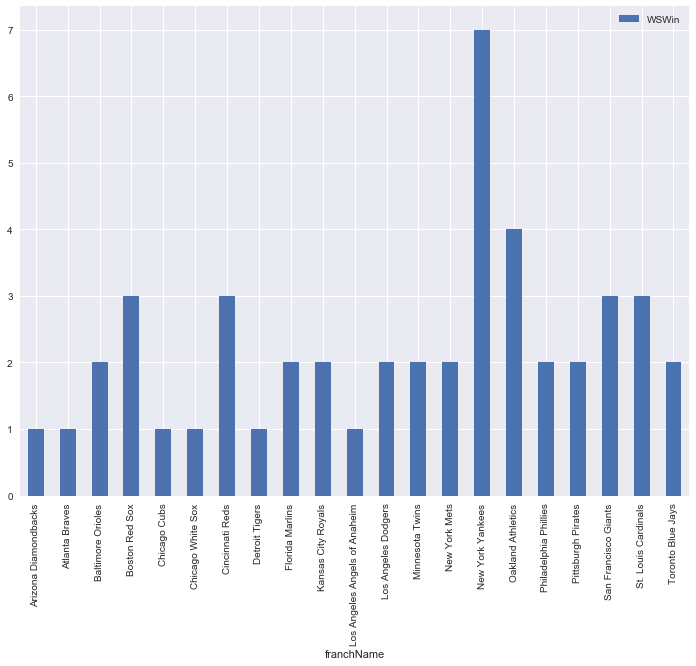

In [80]:
prize_list = prize_list.set_index(prize_list["franchName"])
prize_list = prize_list[(prize_list["WSWin"] > 0)]
prize_list.plot(kind='bar', y=["WSWin"], figsize=(12, 9))

### Teams win ratio

We first calculate win ratio for all teams and seasons:

In [84]:
teams_df = teams_df.assign(winRatio=teams_df["W"] / teams_df["G"])
teams_df.nlargest(20, "winRatio")[["yearID", "franchName", "lgID", "DivWin", "LgWin", "WSWin", "winRatio"]]

,yearID,franchName,lgID,DivWin,LgWin,WSWin,winRatio
2693,2001,Seattle Mariners,AL,1,0,0,0.716049
1408,1998,New York Yankees,AL,1,1,1,0.703704
1753,1995,Cleveland Indians,AL,1,1,0,0.694444
1959,1969,Baltimore Orioles,AL,1,1,0,0.672840
495,1975,Cincinnati Reds,NL,1,1,1,0.666667
1960,1970,Baltimore Orioles,AL,1,1,1,0.666667
2446,1986,New York Mets,NL,1,1,1,0.666667
172,1998,Atlanta Braves,NL,1,0,0,0.654321
2550,1994,Washington Nationals,NL,0,0,0,0.649123
821,2004,St. Louis Cardinals,NL,1,1,0,0.648148


The record has been established in 2001 by the Seattle Mariners. Unfortunately they have not won the league this year. Actually, they never have won the league in their history. The previous record was from 1998 by the New York Yankees, and they had won the World Series the same year.

More surprisingly, Washington Nationals have one of the best win ratio but it they were not division winner. Let's have a closer look to year 1994 in Eastern division of National League:

In [101]:
teams_df[(teams_df["yearID"] == 1994) & (teams_df["lgID"] == "NL") & (teams_df["divID"] == "E")].sort_values("winRatio", ascending=False)

,yearID,lgID,teamID,divID,Rank,G,Ghome,W,L,DivWin,...,SOA,E,DP,FP,name,park,attendance,franchName,active,winRatio
2550,1994,NL,MON,E,1,114,52.0,74,40,0,...,805,94,90.0,0.979,Montreal Expos,Stade Olympique,1276250.0,Washington Nationals,True,0.649123
168,1994,NL,ATL,E,2,114,55.0,68,46,0,...,865,81,85.0,0.982,Atlanta Braves,Atlanta-Fulton County Stadium,2539240.0,Atlanta Braves,True,0.596491
2454,1994,NL,NYN,E,3,113,53.0,55,58,0,...,640,89,112.0,0.980,New York Mets,Shea Stadium,1151471.0,New York Mets,True,0.486726
1086,1994,NL,PHI,E,4,115,60.0,54,61,0,...,699,94,96.0,0.978,Philadelphia Phillies,Veterans Stadium,2290971.0,Philadelphia Phillies,True,0.469565
2774,1994,NL,FLO,E,5,115,59.0,51,64,0,...,649,95,111.0,0.978,Florida Marlins,Joe Robbie Stadium,1937467.0,Florida Marlins,True,0.443478


There is a mismatch between franchName and team name. After a quick check on Wikipedia (https://en.wikipedia.org/wiki/Montreal_Expos) it seems that the Montreal Expos became Washington Nationals in 2004. But the team should have been credited a division win this year (the rank is 1st).

We can have a look how the win ratio of teams has evolved during their history:

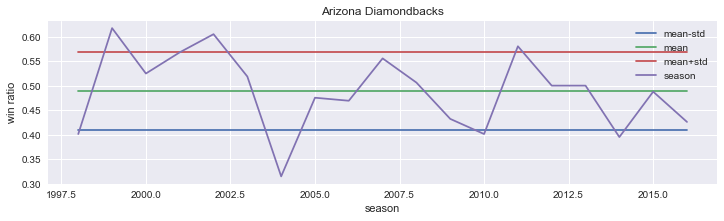

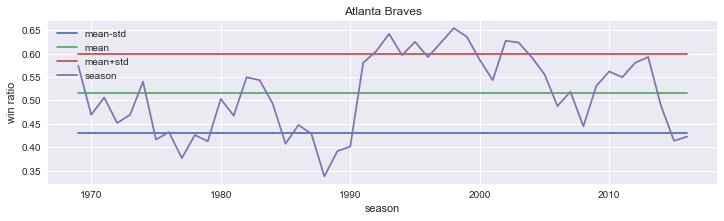

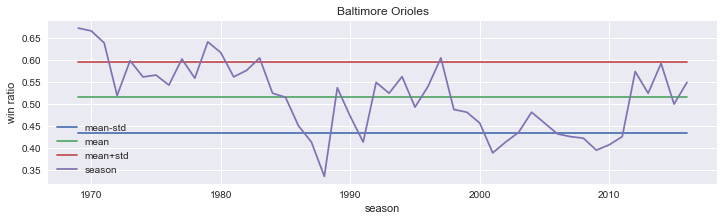

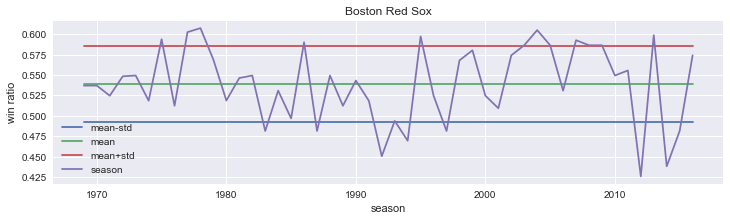

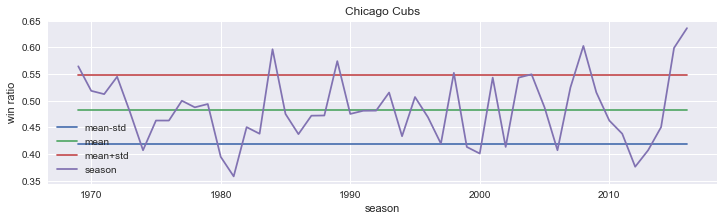

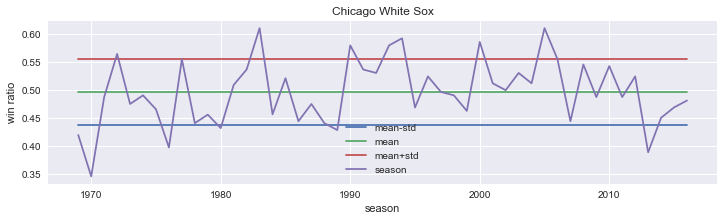

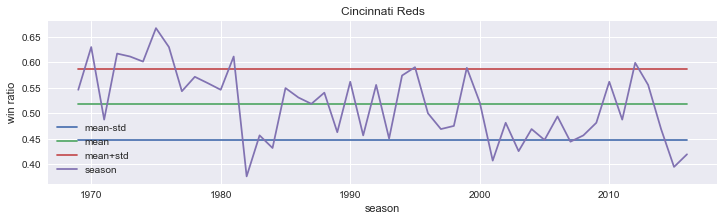

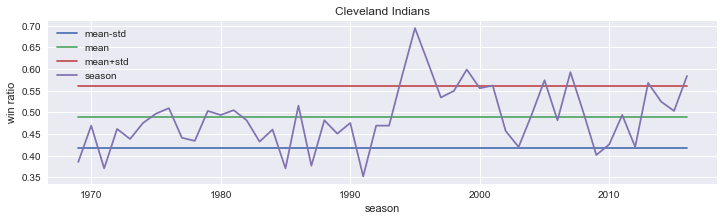

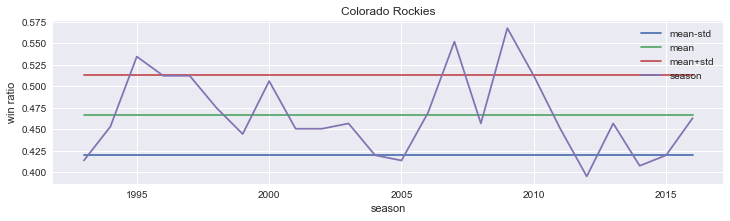

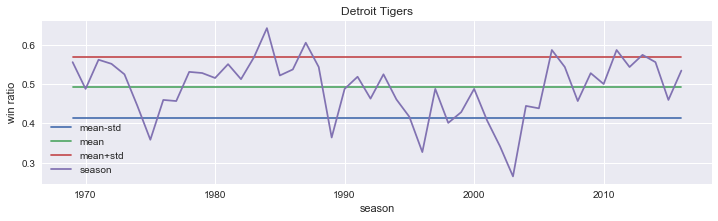

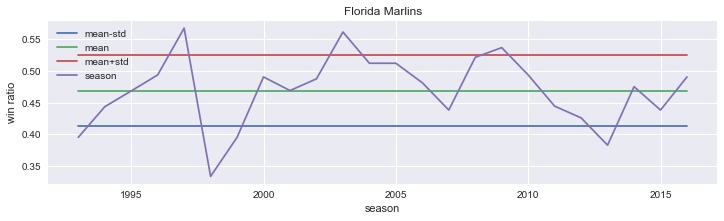

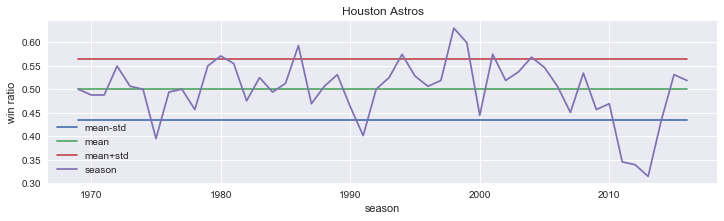

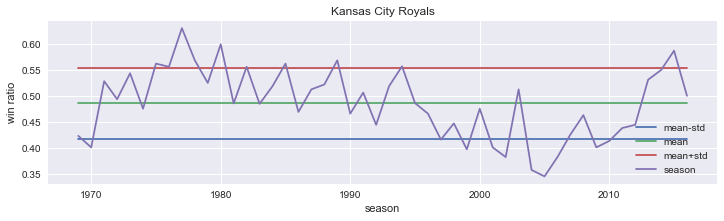

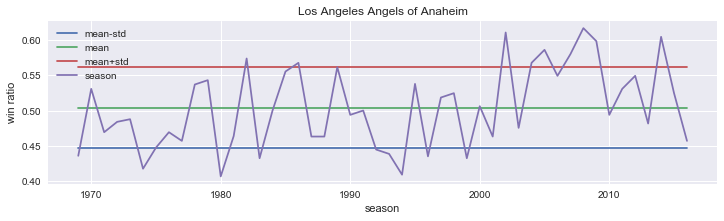

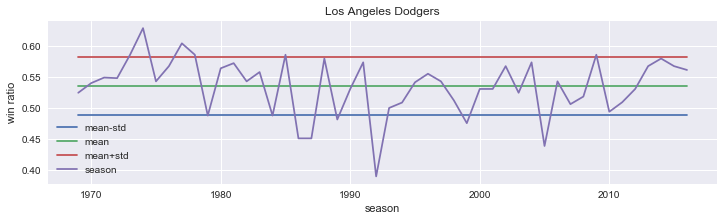

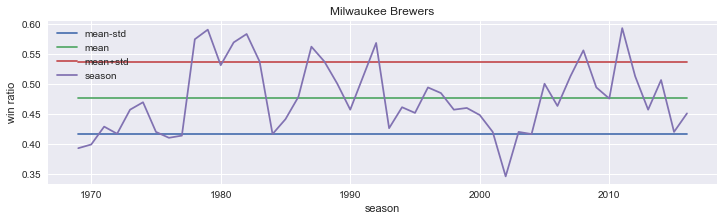

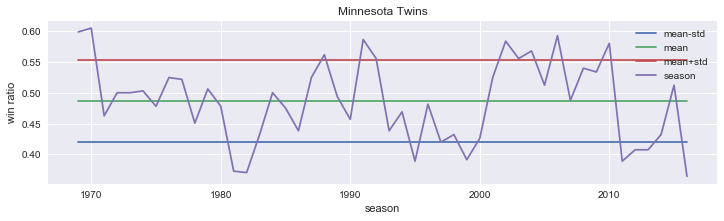

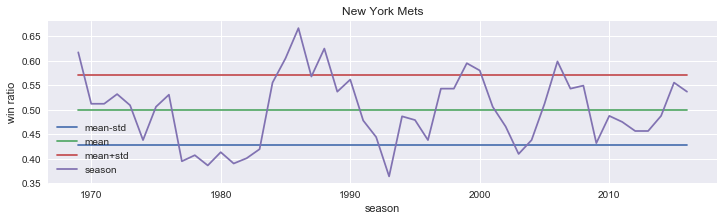

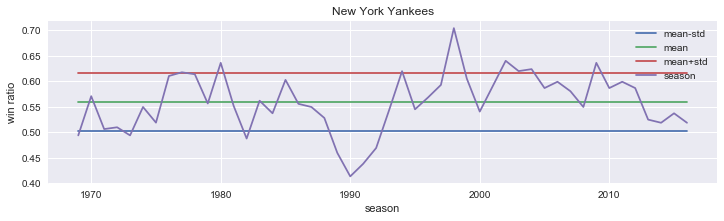

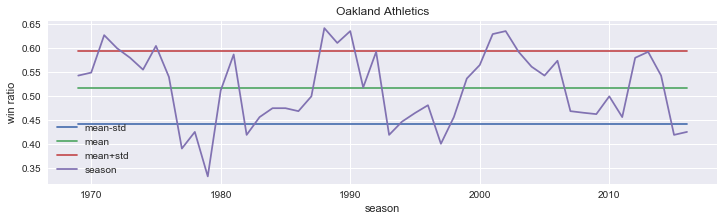

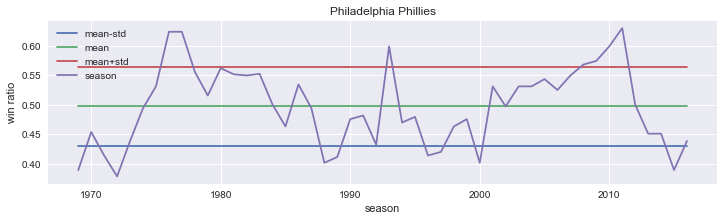

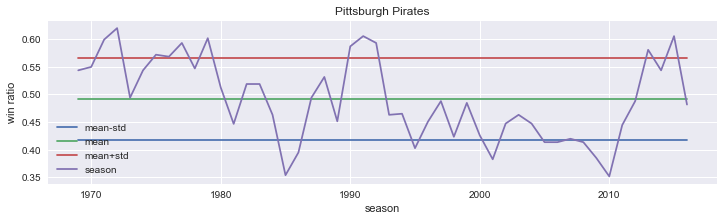

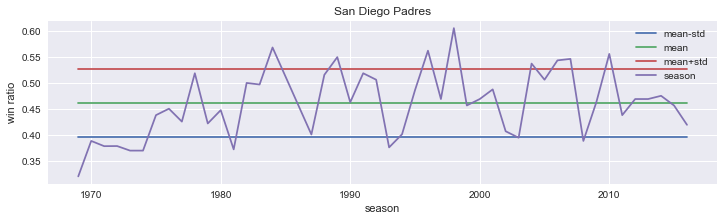

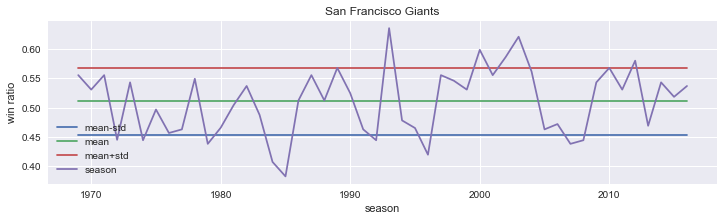

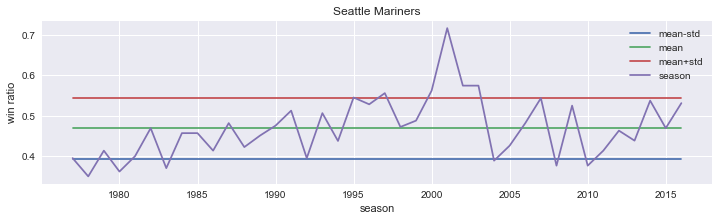

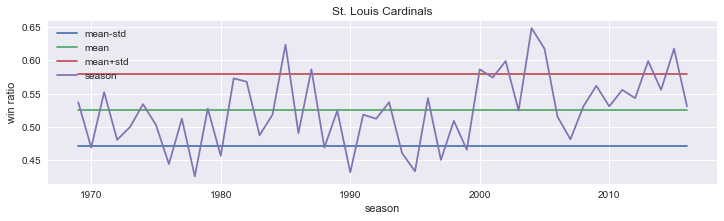

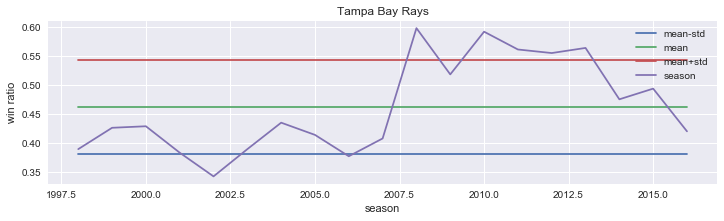

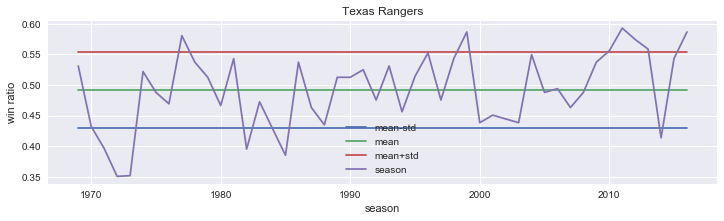

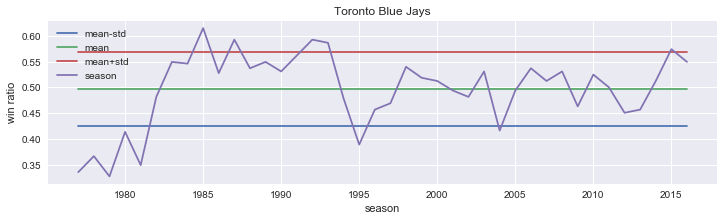

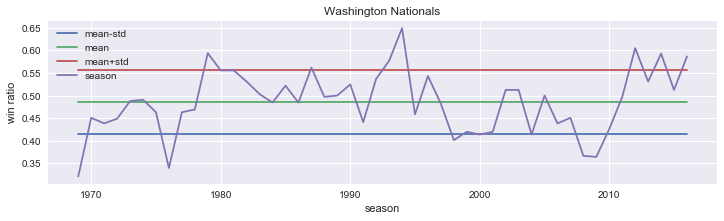

In [169]:
#This aggregate does nothing but enable to get a dataframe as result
win_ratio_years = teams_df.groupby(["franchName", "yearID"], as_index=False).aggregate({"winRatio": lambda x: x})

#Calculate mean and standard deviation for all team history in league
win_ratio_overall = teams_df.groupby(["franchName"], as_index=False).aggregate({"winRatio": ["mean", "std"]})

#Merge both and rename columns
win_ratio = pd.merge(left=win_ratio_years, right=win_ratio_overall, on="franchName", how="inner")
win_ratio = win_ratio.rename(columns={"winRatio": "value", ("winRatio", "mean"): "mean", ("winRatio", "std"): "std"})

for franchName in win_ratio["franchName"].unique():
    labels = ["mean-std", "mean", "mean+std", "season"]
    current_franchise = win_ratio[win_ratio["franchName"] == franchName]
    labels.append(franchName)
    xs = [current_franchise["yearID"]] * 4
    ys = []
    ys.append(current_franchise["mean"] - current_franchise["std"])
    ys.append(current_franchise["mean"])
    ys.append(current_franchise["mean"] + current_franchise["std"])
    ys.append(current_franchise["value"])
    baseball.line_plot(xs, ys, labels=labels, xlabel="season", ylabel="win ratio", figsize=(12, 3), title=franchName)

Chicago Cubs and Texas Rangers had a high increase of their win ratio in the last years. Seattle Mariners win ratio record seems exceptional considering the evolution of this ratio in their history. New York Yankees, which is the team with highest number of wins in World Series have results below average in the last years.

We'll try to explain the exceptional 2001 season of Seattle Mariners later on.

In [182]:
win_ratio_overall.head()
win_ratio_overall.sort_values(("winRatio", "mean"), ascending=False)[:6]

franchName  winRatio          
                             mean       std
18     New York Yankees  0.559163  0.057156
3        Boston Red Sox  0.539367  0.046388
14  Los Angeles Dodgers  0.535581  0.046728
25  St. Louis Cardinals  0.525392  0.054099
19    Oakland Athletics  0.518230  0.076778
6       Cincinnati Reds  0.517226  0.070319

New York Yanks once again is on top of ranking with the best average of win ratio.

In [184]:
prize_list.sort_values("WSWin", ascending=False)[:6]

,franchName,lgID,LgWin,WSWin
franchName,,,,
New York Yankees,New York Yankees,AL,11,7
Oakland Athletics,Oakland Athletics,AL,6,4
Boston Red Sox,Boston Red Sox,AL,5,3
St. Louis Cardinals,St. Louis Cardinals,NL,7,3
San Francisco Giants,San Francisco Giants,NL,5,3
Cincinnati Reds,Cincinnati Reds,NL,5,3


The six teams with the most wins in the World Series are in the top 6 of teams with best average of win ratios. The only exception is Los Angeles Dodgers and San Fransisco Giants. While being one of the most consistent performer Los Angeles Dodgers has less titles in WOrld Series.

### Attendance and performance

We will try to see if there is a correlation between attendance in baseball parks and performance of team (win ratio). As all teams do not have a park with the same capacity, we will standardize the total attendance using z-scores. We will then plot z-score of attendance vs win ratio for all teams for all seasons we have in the dataframe.

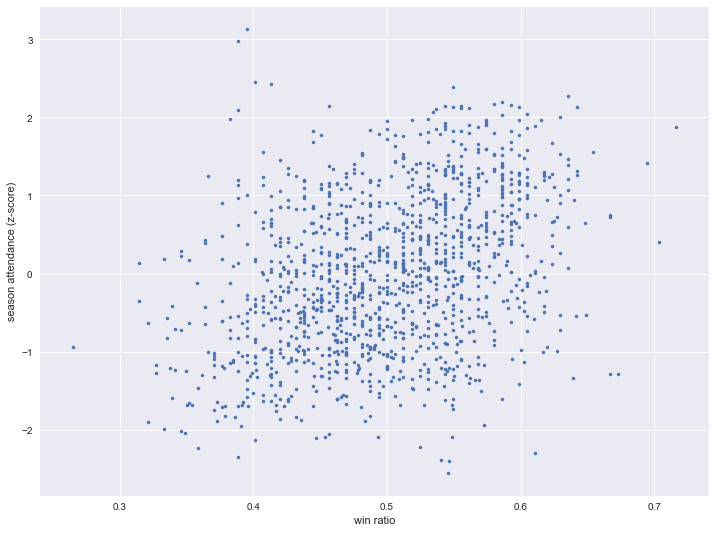

In [202]:
attendance = teams_df[["yearID", "franchName", "attendance", "winRatio"]]
attendance_stand = attendance.groupby("franchName", as_index=False).aggregate({"attendance": ["mean", "std"]})
attendance = attendance.merge(attendance_stand, on="franchName", how="inner")
def zscore(x):
    return (x["attendance"] - x[("attendance", "mean")]) / x[("attendance", "std")]
attendance = attendance.assign(zScore=zscore)
baseball.scatter_plot(attendance['winRatio'], attendance['zScore'], xlabel="win ratio", 
                      ylabel="season attendance (z-score)", size=10)

There is no clear evidence of correlation between win ratio and attendance. The highest attendance (in terms of z-score) was for a win ratio of around 0.4 while we find a z-zcore of ~0.3 for a win ratio of 0.7.

In [203]:
attendance.nlargest(10, "zScore")

,yearID,franchName,attendance,winRatio,"(attendance, mean)","(attendance, std)",zScore
1256,1993,Florida Marlins,3064847.0,0.395062,1.643106e+06,453754.500980,3.133281
1299,1998,Tampa Bay Rays,2506293.0,0.388889,1.487577e+06,341839.642374,2.980098
1280,1998,Arizona Diamondbacks,3610290.0,0.401235,2.453297e+06,470625.798189,2.458413
1232,1993,Colorado Rockies,4483350.0,0.413580,2.949554e+06,632091.662877,2.426540
951,2008,New York Mets,4042045.0,0.549383,2.207541e+06,768948.168658,2.385732
693,1990,Oakland Athletics,2900217.0,0.635802,1.520008e+06,608348.771986,2.268778
1208,1993,Toronto Blue Jays,4057947.0,0.586420,2.346746e+06,779380.814807,2.195591
761,2010,Minnesota Twins,3223640.0,0.580247,1.657048e+06,720341.758810,2.174790
1207,1992,Toronto Blue Jays,4028318.0,0.592593,2.346746e+06,779380.814807,2.157575
517,2006,Chicago White Sox,2957414.0,0.555556,1.687114e+06,589922.481912,2.153333


The four greater z-score are for winRatio of around 0.4.

In [204]:
attendance.nlargest(10, "winRatio")

,yearID,franchName,attendance,winRatio,"(attendance, mean)","(attendance, std)",zScore
1176,2001,Seattle Mariners,3507326.0,0.716049,1.927636e+06,841386.375360,1.877484
413,1998,New York Yankees,2955193.0,0.703704,2.566305e+06,948949.191422,0.409810
554,1995,Cleveland Indians,2842745.0,0.694444,1.606295e+06,870081.099391,1.421074
624,1969,Baltimore Orioles,1062069.0,0.672840,2.142540e+06,838720.800948,-1.288237
102,1975,Cincinnati Reds,2315603.0,0.666667,2.015369e+06,401184.646735,0.748369
625,1970,Baltimore Orioles,1057069.0,0.666667,2.142540e+06,838720.800948,-1.294199
929,1986,New York Mets,2767601.0,0.666667,2.207541e+06,768948.168658,0.728346
29,1998,Atlanta Braves,3360860.0,0.654321,1.948599e+06,907893.379145,1.555537
1033,1994,Washington Nationals,1276250.0,0.649123,1.587270e+06,587188.013840,-0.529677
227,2004,St. Louis Cardinals,3048427.0,0.648148,2.538632e+06,785635.934393,0.648895


We even found negative z-score for the 4th better win ratio in history. But the exceptional season of Seattle Mariners coincides with an attendance much larger.